# Pip Install

In [1]:
!pip install boto3

  Using cached boto3-1.26.50-py3-none-any.whl (132 kB)
  Using cached s3transfer-0.6.0-py3-none-any.whl (79 kB)
  Using cached botocore-1.29.50-py3-none-any.whl (10.3 MB)
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)


In [2]:
!pip install astropy

  Using cached astropy-5.2.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (11.2 MB)
  Using cached pyerfa-2.0.0.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (743 kB)


In [3]:
!pip install sfdmap

  Using cached sfdmap-0.1.1-py3-none-any.whl


In [4]:
!pip install progressbar2

  Using cached progressbar2-4.2.0-py2.py3-none-any.whl (27 kB)
  Using cached python_utils-3.4.5-py2.py3-none-any.whl (23 kB)


# Initialization

In [5]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import boto3
from matplotlib import pyplot as plt

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'thesis2')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'thesis2')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_final_table_csv_path = os.path.join(s3_data_dir_path, 'SDSS_DR16_all.csv')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig

# Load the Dataset Info

In [6]:
# loading the table
final_table_csv_path = os.path.join(endpoint_url,bucket_name,s3_final_table_csv_path)
gs = pd.read_csv(final_table_csv_path, header = 0, dtype = {
    'specobjid' : str,
    'z' : float,
    'z_noqso' : float,
    'snMedian' : float,
    'run2d' : str,
    'ra' : float,
    'dec' : float,
    'plate' : int,
    'mjd' : int,
    'fiberid' : int,
    'waveMin' : float,
    'waveMax' : float
    })
print('Total galaxies in DR16: %d' % len(gs))

Total galaxies in DR16: 3234563


# Filter and Merge with other Data Sources

## Filter by SNR and Z

In [7]:
# parameters
snr_th = 0.6
z_th = 0.03

# init counter
cnt = len(gs)
total_filtered = 0

# Remove galaxies with low redshift
gs = gs[gs.z > z_th]
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print('Total galaxies filtered with low z values: %d' % filtered)
cnt = len(gs)
total_filtered += filtered

# Remove galaxies with low SNR
gs = gs[gs.snMedian > snr_th]
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print('Total galaxies filtered with low snr values: %d' % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered with low z values: 94412
Total galaxies filtered with low snr values: 172465


## Merge with Dalya's Scores

In [8]:
# adding Dalya's scores
dalya_scores_URL = 'http://wise-obs.tau.ac.il/~dovip/weird-galaxies/full.csv'
dalya_df = pd.read_csv(dalya_scores_URL)
dalya_df = dalya_df.rename(columns={" mjd":"mjd"," fiber":"fiberid", " weirdness":"weirdness"})
gs = gs.merge(dalya_df, how='inner', on=['plate', 'mjd', 'fiberid'])
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print("Total galaxies filtered after merging with Dalya's scores: %d" % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered after merging with Dalya's scores: 969726


## Merge with galSpecLine and galSpecInfo

In [9]:
# Merge with galSpecInfo

galSpecInfo = pd.read_csv(os.path.join(endpoint_url, bucket_name, s3_data_dir_path, 'galSpecInfo.csv'), header = 0, dtype = {
    'specobjid' : str,
    'plateid' : int,
    'mjd' : int,
    'fiberid' : int,
    'spectrotype' : str,
    'subclass' : str
    })

galSpecInfo = galSpecInfo.rename(columns={"plateid":"plate"})
gs = gs.merge(galSpecInfo, how='inner', on=['specobjid', 'plate', 'mjd', 'fiberid'])
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print("Total galaxies filtered after merging with galSpecInfo: %d" % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered after merging with galSpecInfo: 1267075


In [10]:
# Merge with galSpecLine

galSpecLine = pd.read_csv(os.path.join(endpoint_url, bucket_name, s3_data_dir_path, 'galSpecLine.csv'), header = 0, dtype = {
    'specobjid' : str,
    'oii_3726_eqw' : float,
    'oii_3729_eqw' : float,
    'neiii_3869_eqw' : float,
    'h_delta_eqw' : float,
    'h_gamma_eqw' : float,
    'oiii_4363_eqw' : float,
    'h_beta_eqw' : float,
    'oiii_4959_eqw' : float,
    'oiii_5007_eqw' : float,
    'hei_5876_eqw' : float,
    'oi_6300_eqw' : float,
    'nii_6548_eqw' : float,
    'h_alpha_eqw' : float,
    'nii_6584_eqw' : float,
    'sii_6717_eqw' : float,
    'sii_6731_eqw' : float,
    'ariii7135_eqw' : float
    })

gs = gs.merge(galSpecLine, how='inner', on=['specobjid'])
gs.index = np.arange(len(gs))
filtered = cnt-len(gs)
print("Total galaxies filtered after merging with galSpecLine: %d" % filtered)
cnt = len(gs)
total_filtered += filtered

Total galaxies filtered after merging with galSpecLine: 0


## Filter by wavelength

100% (676 of 676) |######################| Elapsed Time: 0:00:40 Time:  0:00:40


Text(0.5, 1.0, 'Dataset support')

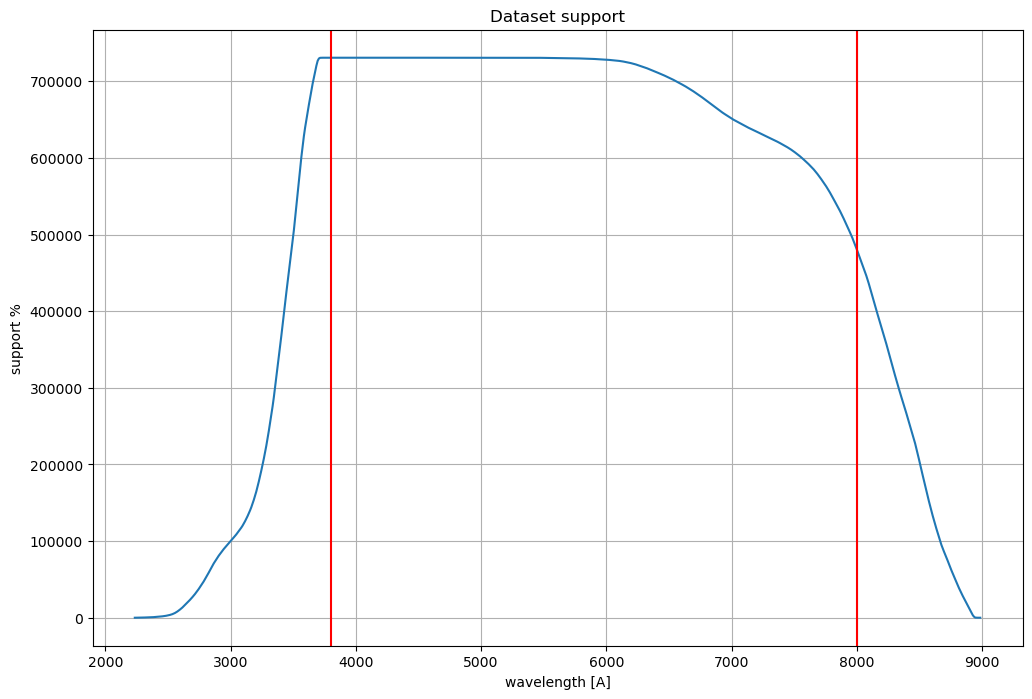

In [11]:
wl_grid = np.arange(3800, 8000, 0.5)

# calculate support
gs['waveMin_rest'] = np.divide(gs.waveMin,1+gs.z)
gs['waveMax_rest'] = np.divide(gs.waveMax,1+gs.z)

# calculate support over a coarse grid
wl = np.arange(min(gs['waveMin_rest']),max(gs['waveMax_rest']),10)
support = np.zeros(shape=wl.shape)
from progressbar import progressbar
for i in progressbar(range(len(wl))):
    support[i] = sum((gs['waveMin_rest']<wl[i])&(gs['waveMax_rest']>wl[i]))    

# plot the support of the dataset
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(wl, support)
plt.grid()
plt.axvline(x=wl_grid[0], ymin=0, ymax=1, c='r')
plt.axvline(x=wl_grid[-1], ymin=0, ymax=1, c='r')
ax.set_xlabel('wavelength [A]')
ax.set_ylabel('support %')
ax.set_title('Dataset support')

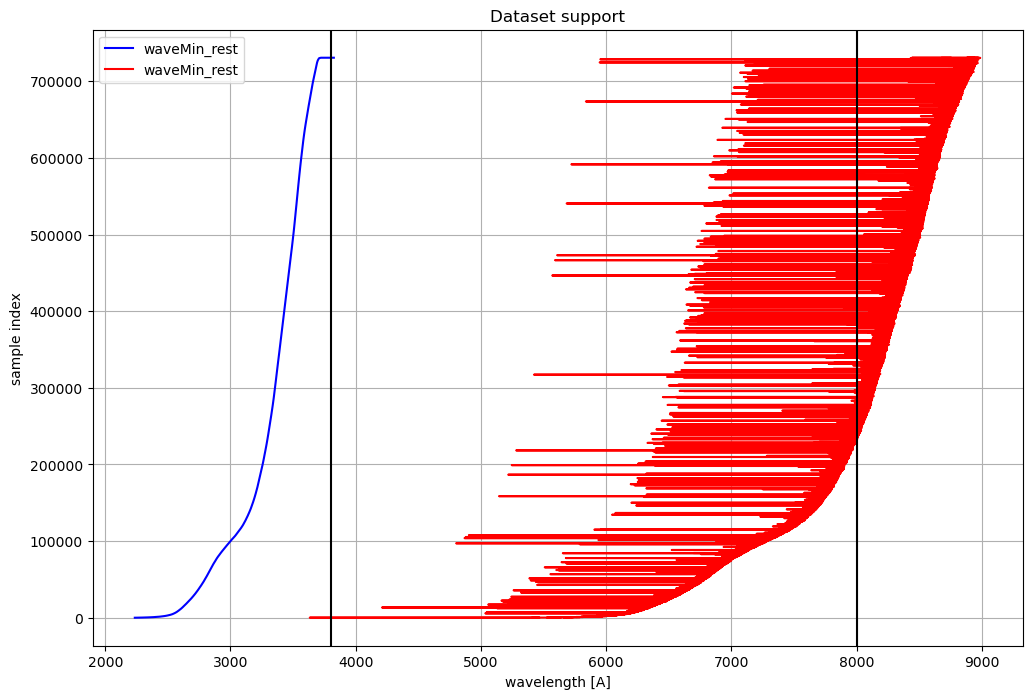

In [12]:
# plot the support of each object
gs_sorted = gs.sort_values(by=['waveMin_rest','waveMax_rest'])
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(gs_sorted['waveMin_rest'],np.arange(len(gs)),c='b',label='waveMin_rest')
ax.plot(gs_sorted['waveMax_rest'],np.arange(len(gs)),c='r',label='waveMin_rest')
plt.grid()
plt.axvline(x=wl_grid[0], ymin=0, ymax=1, c='k')
plt.axvline(x=wl_grid[-1], ymin=0, ymax=1, c='k')
ax.set_xlabel('wavelength [A]')
ax.set_ylabel('sample index')
ax.set_title('Dataset support')
plt.legend()

In [13]:
# filter by wavelength
gs_filtered = gs[(gs['waveMin_rest']<wl_grid[0])&(gs['waveMax_rest']>wl_grid[-1])]
gs_filtered.index = np.arange(len(gs_filtered))
print('Total number of galaxies left: %d' % len(gs_filtered))

Total number of galaxies left: 481049


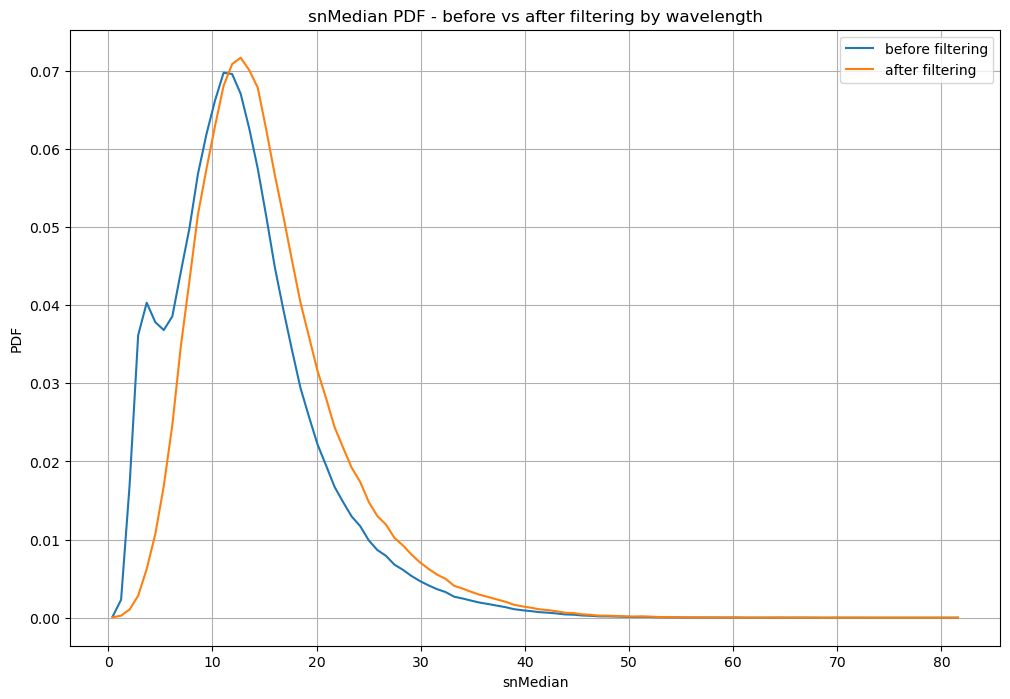

In [14]:
# plot SNR distribution before and after filtering
snr_edges = np.linspace(0,np.ceil(max(gs.snMedian)),101)
snr = (snr_edges[:-1]+snr_edges[1:])/2
gs_pdf, _ = np.histogram(gs.snMedian, bins=snr_edges, density=True)
gs_filtered_pdf, _ = np.histogram(gs_filtered.snMedian, bins=snr_edges, density=True)
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(snr, gs_pdf, label='before filtering')
ax.plot(snr, gs_filtered_pdf, label='after filtering')
ax.set_xlabel('snMedian')
ax.set_ylabel('PDF')
ax.set_title('snMedian PDF - before vs after filtering by wavelength')
plt.legend()
plt.grid()

# Create the datasets for the models

In [15]:
# create Large RF dataset (110K = 100K train + 10K validation)
gs_largeRF = gs_filtered.sample(110000, random_state=seed)
gs_largeRF.index = np.arange(len(gs_largeRF))
gs_largeRF_val = gs_largeRF.sample(10000, random_state=seed)
gs_largeRF_train =  pd.concat([gs_largeRF,gs_largeRF_val]).drop_duplicates(keep=False)

In [16]:
# split to 2 halves
gs_half_1 = gs_largeRF_train.sample(50000, random_state=seed)
gs_half_2 =  pd.concat([gs_largeRF_train,gs_half_1]).drop_duplicates(keep=False)

In [17]:
# create Small RF dataset (12.1K = 11K train + 1.1K validation
gs_smallRF = gs_half_1.sort_values(by='snMedian', ascending=False).iloc[:12100]
gs_smallRF_val = gs_smallRF.sample(1100, random_state=seed)
gs_smallRF_train =  pd.concat([gs_smallRF,gs_smallRF_val]).drop_duplicates(keep=False)

In [18]:
# split NN dataset (small RF training set) to 10K train and 1K validation
gs_NN_val = gs_smallRF_train.sample(1000, random_state=seed)
gs_NN_train =  pd.concat([gs_smallRF_train,gs_NN_val]).drop_duplicates(keep=False)

In [19]:
# create NN and Small RF test set
gs_test = gs_half_2.sample(10000, random_state=seed)

# Download and pre-process the data

In [20]:
# create a wrapper that returns the index also
from pre_processing import download_spectrum
def download_spectrum_wrapper(i):
    spec, _, ivar = download_spectrum(gs_largeRF.iloc[i], pre_proc=True, wl_grid=wl_grid)
    return i, spec, ivar

In [21]:
# create jobs to download and preprocess
from joblib import Parallel, delayed
res = Parallel(n_jobs=-1, verbose=5, prefer="threads")(delayed(download_spectrum_wrapper)(i) for i in range(len(gs_largeRF)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2114 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2528 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2978 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3464 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4544 tasks    

In [22]:
# make sure all the data was successfully downloaded (exception encountered during download will return empty arrays)
assert all([len(val[1]) > 0 for val in res])

In [23]:
# organize the results to matrices
res = sorted(res, key=lambda x: x[0])
spec = np.stack([x[1] for x in res], axis=0)
ivar = np.stack([x[2] for x in res], axis=0)

# Save datasets

## Big RF Dataset

In [24]:
to_s3_pkl(gs_largeRF, s3_client, bucket_name, os.path.join(s3_data_dir_path,'BigRF','gs.pkl'))
to_s3_npy(spec, s3_client, bucket_name, os.path.join(s3_data_dir_path,'BigRF','spec.npy'))
to_s3_npy(ivar, s3_client, bucket_name, os.path.join(s3_data_dir_path,'BigRF','ivar.npy'))
to_s3_npy(wl_grid, s3_client, bucket_name, os.path.join(s3_data_dir_path,'BigRF','wl_grid.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/data/BigRF/gs.pkl
saving to uri: s3://tau-astro/almogh/thesis2/data/BigRF/spec.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/BigRF/ivar.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/BigRF/wl_grid.npy


True

In [25]:
to_s3_pkl(gs_largeRF_train, s3_client, bucket_name, os.path.join(s3_data_dir_path,'BigRF','train','gs.pkl'))
to_s3_npy(spec[gs_largeRF_train.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'BigRF','train','spec.npy'))
to_s3_npy(ivar[gs_largeRF_train.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'BigRF','train','ivar.npy'))
to_s3_npy(wl_grid, s3_client, bucket_name, os.path.join(s3_data_dir_path,'BigRF','train','wl_grid.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/data/BigRF/train/gs.pkl
saving to uri: s3://tau-astro/almogh/thesis2/data/BigRF/train/spec.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/BigRF/train/ivar.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/BigRF/train/wl_grid.npy


True

In [26]:
to_s3_pkl(gs_largeRF_val, s3_client, bucket_name, os.path.join(s3_data_dir_path,'BigRF','val','gs.pkl'))
to_s3_npy(spec[gs_largeRF_val.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'BigRF','val','spec.npy'))
to_s3_npy(ivar[gs_largeRF_val.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'BigRF','val','ivar.npy'))
to_s3_npy(wl_grid, s3_client, bucket_name, os.path.join(s3_data_dir_path,'BigRF','val','wl_grid.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/data/BigRF/val/gs.pkl
saving to uri: s3://tau-astro/almogh/thesis2/data/BigRF/val/spec.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/BigRF/val/ivar.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/BigRF/val/wl_grid.npy


True

## Small RF Dataset

In [27]:
to_s3_pkl(gs_smallRF, s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','gs.pkl'))
to_s3_npy(spec[gs_smallRF.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','spec.npy'))
to_s3_npy(ivar[gs_smallRF.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','ivar.npy'))
to_s3_npy(wl_grid, s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','wl_grid.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/gs.pkl
saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/spec.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/ivar.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/wl_grid.npy


True

In [28]:
to_s3_pkl(gs_smallRF_train, s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','train','gs.pkl'))
to_s3_npy(spec[gs_smallRF_train.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','train','spec.npy'))
to_s3_npy(ivar[gs_smallRF_train.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','train','ivar.npy'))
to_s3_npy(wl_grid, s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','train','wl_grid.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/train/gs.pkl
saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/train/spec.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/train/ivar.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/train/wl_grid.npy


True

In [29]:
to_s3_pkl(gs_smallRF_val, s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','val','gs.pkl'))
to_s3_npy(spec[gs_smallRF_val.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','val','spec.npy'))
to_s3_npy(ivar[gs_smallRF_val.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','val','ivar.npy'))
to_s3_npy(wl_grid, s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','val','wl_grid.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/val/gs.pkl
saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/val/spec.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/val/ivar.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/val/wl_grid.npy


True

## NN Dataset

In [30]:
to_s3_pkl(gs_smallRF_train, s3_client, bucket_name, os.path.join(s3_data_dir_path,'NN','gs.pkl'))
to_s3_npy(spec[gs_smallRF_train.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'NN','spec.npy'))
to_s3_npy(ivar[gs_smallRF_train.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'NN','ivar.npy'))
to_s3_npy(wl_grid, s3_client, bucket_name, os.path.join(s3_data_dir_path,'NN','wl_grid.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/data/NN/gs.pkl
saving to uri: s3://tau-astro/almogh/thesis2/data/NN/spec.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/NN/ivar.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/NN/wl_grid.npy


True

In [31]:
to_s3_pkl(gs_NN_train, s3_client, bucket_name, os.path.join(s3_data_dir_path,'NN','train','gs.pkl'))
to_s3_npy(spec[gs_NN_train.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'NN','train','spec.npy'))
to_s3_npy(ivar[gs_NN_train.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'NN','train','ivar.npy'))
to_s3_npy(wl_grid, s3_client, bucket_name, os.path.join(s3_data_dir_path,'NN','train','wl_grid.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/data/NN/train/gs.pkl
saving to uri: s3://tau-astro/almogh/thesis2/data/NN/train/spec.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/NN/train/ivar.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/NN/train/wl_grid.npy


True

In [32]:
to_s3_pkl(gs_NN_val, s3_client, bucket_name, os.path.join(s3_data_dir_path,'NN','val','gs.pkl'))
to_s3_npy(spec[gs_NN_val.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'NN','val','spec.npy'))
to_s3_npy(ivar[gs_NN_val.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'NN','val','ivar.npy'))
to_s3_npy(wl_grid, s3_client, bucket_name, os.path.join(s3_data_dir_path,'NN','val','wl_grid.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/data/NN/val/gs.pkl
saving to uri: s3://tau-astro/almogh/thesis2/data/NN/val/spec.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/NN/val/ivar.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/NN/val/wl_grid.npy


True

## Test Set

In [ ]:
to_s3_pkl(gs_test, s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','test','gs.pkl'))
to_s3_npy(spec[gs_test.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','test','spec.npy'))
to_s3_npy(ivar[gs_test.index,:], s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','test','ivar.npy'))
to_s3_npy(wl_grid, s3_client, bucket_name, os.path.join(s3_data_dir_path,'SmallRF','test','wl_grid.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/test/gs.pkl
saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/test/spec.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/test/ivar.npy
saving to uri: s3://tau-astro/almogh/thesis2/data/SmallRF/test/wl_grid.npy
